# Model testing

- It's just a testing ground for the model. One model is loaded and a `cmc.test_model` is applied on it.
- As a result confusion matrix, ROC, AUROC, F1, PR curves will be generated and saved to the model's folder

In [1]:
from skimage.metrics import structural_similarity as ssim
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchmetrics.classification import BinaryPrecision, BinaryRecall, F1Score
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
import numpy as np
from PIL import Image
import random
import json
import time
from torchmetrics.classification import MulticlassConfusionMatrix, F1Score, MulticlassPrecision, MulticlassRecall
from PhyDNet.models.models_modified import ConvLSTM,PhyCell, ClassifierRNN
from PhyDNet.data.moving_mnist import MovingMNIST
from sklearn.metrics import cohen_kappa_score, precision_score, recall_score, f1_score
from PhyDNet.constrain_moments import K2M
import torch.multiprocessing as mp

from tqdm import tqdm
import os
import re
import pandas as pd
from torchvision.io import read_image
from datetime import datetime
from pathlib import Path
import confinement_mode_classifier as cmc
from torch.utils.tensorboard import SummaryWriter

import PhyDNet_COMPASS as pdnt
mp.set_start_method('spawn')

In [2]:
batch_size=8
learning_rate_min=0.0001
learning_rate_max=0.01
num_epochs=16

test_run=False
test_df_contains_val_df=True
n_frames_input=4
num_workers=4
path = Path(os.getcwd())
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [3]:
save_name = '24-05-08, 14-41-10  phydnet'

shot_usage = pd.read_csv(f'{path}/data/shot_usageNEW.csv')
shot_for_ris = shot_usage[shot_usage['used_for_ris1']]
shot_numbers = shot_for_ris['shot']
shots_for_testing = shot_for_ris[shot_for_ris['used_as'] == 'test']['shot']
shots_for_validation = shot_for_ris[shot_for_ris['used_as'] == 'val']['shot']
shots_for_training = shot_for_ris[shot_for_ris['used_as'] == 'train']['shot']
if test_df_contains_val_df:
    shots_for_testing = pd.concat([shots_for_testing, shots_for_validation])
if test_run:
    shots_for_testing = shots_for_testing[2:4]
    shots_for_validation = shots_for_validation[2:4]
    shots_for_training = shots_for_training[2:4]
shot_df, test_df, val_df, train_df = cmc.load_and_split_dataframes(path,shot_numbers, shots_for_training, shots_for_testing, 
                                                                shots_for_validation, use_ELMS=True, ris_option='RIS1',exponential_elm_decay=True)
#Read article, see PhyDNet/constrain_moments.py
constraints = torch.zeros((49,7,7)).to(device)
ind = 0
for i in range(0,7):
    for j in range(0,7):
        constraints[ind,i,j] = 1
        ind +=1   

test_loader = pdnt.get_loader(test_df, batch_size=batch_size, num_workers=num_workers, n_frames_input=n_frames_input, path=path, balance=False)

In [4]:
phycell  =  PhyCell(input_shape=(88,88), input_dim=352, F_hidden_dims=[49], n_layers=1, kernel_size=(7,7), device=device) 
convcell =  ConvLSTM(input_shape=(88,88), input_dim=352, hidden_dims=[8,352], n_layers=2, kernel_size=(3,3), device=device)   
classifier = ClassifierRNN(phycell, convcell, device)

classifier.load_state_dict(torch.load(f'PhyDNet/runs/{save_name}/model_chkpt.pt'))
classifier.eval()

writer = SummaryWriter(f'PhyDNet/runs/{save_name}')
criterion = nn.CrossEntropyLoss()

layer  0 input dim  352  hidden dim  8
layer  1 input dim  8  hidden dim  352


Processing batches:   0%|          | 0/8087 [00:00<?, ?it/s]

Processing batches: 100%|██████████| 8087/8087 [48:18<00:00,  2.79it/s]


Processing metrics...


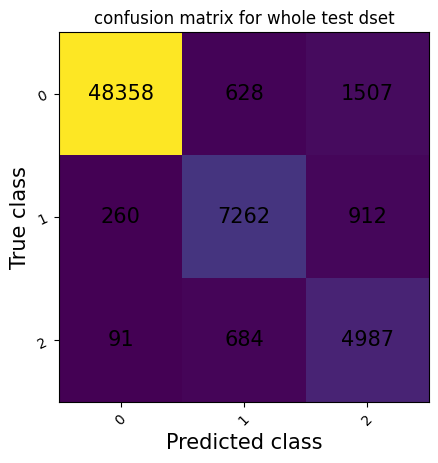

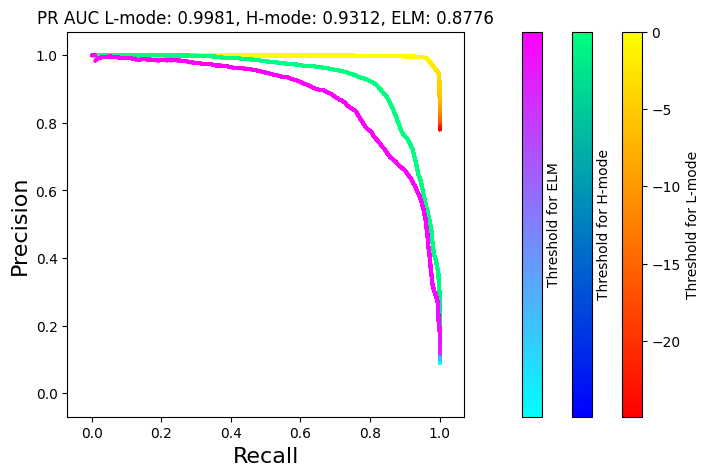

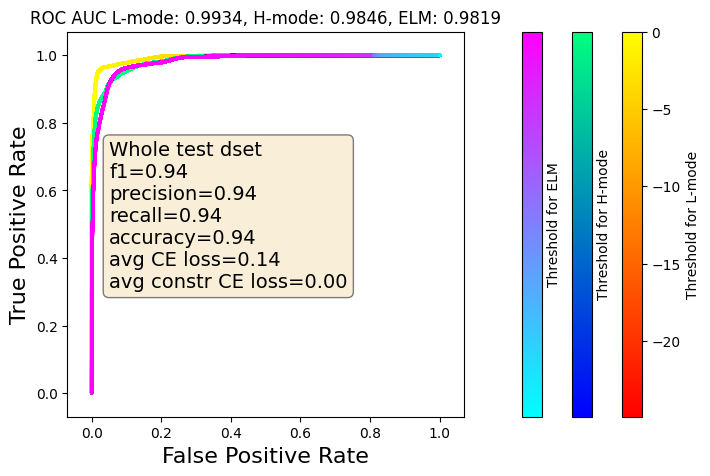

In [5]:
metrics = pdnt.test_model(f'PhyDNet/runs/{save_name}', classifier, test_loader,
                              comment='', writer=writer, signal_name='imgs_input', num_classes=3, 
                              constraints=constraints, criterion=criterion)

In [6]:
results_df = pd.read_csv(f'PhyDNet/runs/{save_name}/prediction_df.csv', index_col=0)

In [7]:
from importlib import reload
reload(pdnt)
reload(cmc)

<module 'confinement_mode_classifier' from '/compass/Shared/Users/bogdanov/vyzkumny_ukol/confinement_mode_classifier.py'>

In [19]:
metrics['prediction_df'].to_csv(f'PhyDNet/runs/{save_name}/prediction_df.csv')

metrics_per_shot = cmc.per_shot_test(path=f'PhyDNet/runs/{save_name}', 
                        shots=shots_for_testing.values.tolist(), results_df=metrics['prediction_df'],
                        writer=writer, num_classes=3,
                        two_images=False)

metrics_per_shot = pd.DataFrame(metrics_per_shot)
metrics_per_shot.to_csv(f'PhyDNet/runs/{save_name}/metrics_per_shot.csv')

  6%|▋         | 2/32 [00:00<00:09,  3.22it/s]/compass/Shared/Users/bogdanov/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:697: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
 44%|████▍     | 14/32 [00:04<00:06,  3.00it/s]/compass/Shared/Users/bogdanov/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:697: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
 50%|█████     | 16/32 [00:05<00:05,  3.12it/s]/compass/Shared/Users/bogdanov/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:697: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
 53%|█████▎    | 17/32 [00:05<00:04,  3.19it/s]/compass/Shared/Users/bogdanov/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:697: RuntimeWarning: invalid value encounter

In [13]:
metrics

{'prediction_df':         shot prediction  label    time  prob_0      prob_1      prob_2
 0      16534          0      0   960.2     0.0  -22.618122  -21.067472
 1      16534          0      0   960.4     0.0  -22.562767  -18.659906
 2      16534          0      0   960.6     0.0  -28.997408  -22.991905
 3      16534          0      0   960.8     0.0  -28.439823  -22.221605
 4      16534          0      0   961.0     0.0  -22.619183  -18.052608
 ...      ...        ...    ...     ...     ...         ...         ...
 64684  19379          0      0  1329.0     0.0 -191.742752 -201.645203
 64685  19379          0      0  1329.2     0.0 -191.959717 -199.204590
 64686  19379          0      0  1329.4     0.0 -185.842865 -199.081116
 64687  19379          0      0  1329.6     0.0 -183.915970 -193.280060
 64688  19379  tensor(0)      0  1329.8     0.0 -190.388901 -202.439575
 
 [64689 rows x 7 columns],
 'confusion_matrix': (<Figure size 640x480 with 1 Axes>,
  <Axes: title={'center': 'confus

In [17]:
tensor_probs = torch.tensor(metrics['prediction_df'][['prob_0', 'prob_1', 'prob_2']].values).to(device)
tensor_probs = torch.softmax(tensor_probs, dim=1)

metrics['prediction_df'][['prob_0', 'prob_1', 'prob_2']] = tensor_probs.cpu().numpy()

In [18]:
metrics['prediction_df'].to_csv(f'PhyDNet/runs/{save_name}/prediction_df.csv')